* **기후정보학및실습** HW7
조선아(2173112)
* 분석 기간: 1982-2022 (41년)
* 95% 신뢰수준 설정

In [ ]:
# 라이브러리 불러오기
!pip install cartopy

import xarray as xr
import numpy as np
import urllib.request

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs

import scipy.stats as stats

We will repeat HW#6, except that we will use the bootstrapping method for the statistical testing.
Compute DJF precipitation anomalies associated with the ENSO.

In [ ]:
# OISSTv2 데이터 불러오기
fsst = f'https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2/sst.mnmean.nc'
urllib.request.urlretrieve(fsst, 'fsst.nc')
sst = xr.open_dataset('fsst.nc')['sst'].sel(time=slice('1982', '2022'))

In [ ]:
# climatology 계산 후 제거하여 anomaly 생성
sst_clim = sst.groupby('time.month').mean('time')
sst_anom = sst.groupby('time.month') - sst_clim
# DJF 데이터 선택
sst_anom_DJF = sst_anom.sel(time=((sst_anom['time.month'] == 12) |(sst_anom['time.month'] == 1) | (sst_anom['time.month'] == 2)))

# NINO.4 구역 설정
lon_min, lon_max = 190, 240
lat_min, lat_max = -5, 5

# NINO.4 구역의 SST를 평균하여 정규화
nino34 = sst_anom.where((sst_anom.lon >= lon_min) & (sst_anom.lon <= lon_max) &
                           (sst_anom.lat >= lat_min) & (sst_anom.lat <= lat_max)).mean(dim=['lat', 'lon'], skipna=True)
nino34_norm = (nino34 - nino34.mean()) / nino34.std()

# DJF 데이터 선택
nino34_DJF = nino34_norm.sel(time=((nino34_norm['time.month'] == 12) |(nino34_norm['time.month'] == 1) | (nino34_norm['time.month'] == 2)))

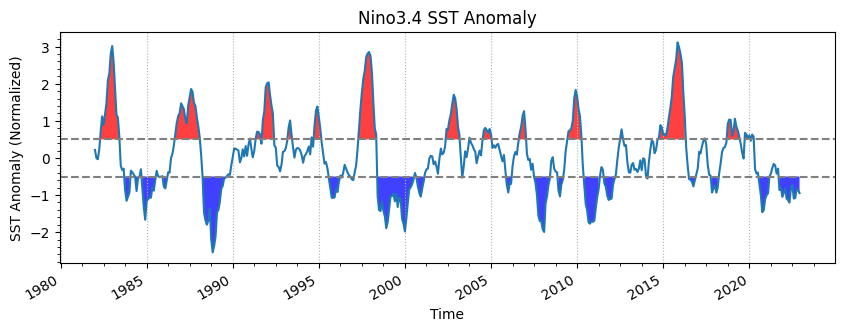

In [ ]:
fig = plt.figure(figsize=(10, 3))
ax = plt.axes()

nino34_norm.plot(ax=ax, label='Nino3.4 SST Anomaly')

ax.axhline(y=0.5, color='gray', linestyle='--')
ax.axhline(y=-0.5, color='gray', linestyle='--')

ax.fill_between(nino34_norm.time.values, 0.5, nino34_norm, where=nino34_norm > 0.5, facecolor='red', alpha=0.75)
ax.fill_between(nino34_norm.time.values, -0.5, nino34_norm, where=nino34_norm < -0.5, facecolor='blue', alpha=0.75)
ax.minorticks_on()
ax.grid(which='major', axis='x', linestyle=':')

ax.set_title('Nino3.4 SST Anomaly')
ax.set_xlabel('Time')
ax.set_ylabel('SST Anomaly (Normalized)')

plt.show()

In [ ]:
# GPCP precipitation 데이터 불러오기
fprecip = f'https://downloads.psl.noaa.gov/Datasets/gpcp/precip.mon.mean.nc'
urllib.request.urlretrieve(fprecip, 'fprecip.nc')
precip = xr.open_dataset('fprecip.nc')['precip'].sel(time=slice('1982', '2022'))

# climatology 계산 후 제거하여 anomaly 생성
precip_clim = precip.groupby('time.month').mean('time')
precip_anom = precip.groupby('time.month') - precip_clim

# DJF 데이터 선택
precip_anom_DJF = precip_anom.sel(time=((precip_anom['time.month'] == 12) |(precip_anom['time.month'] == 1) | (precip_anom['time.month'] == 2)))

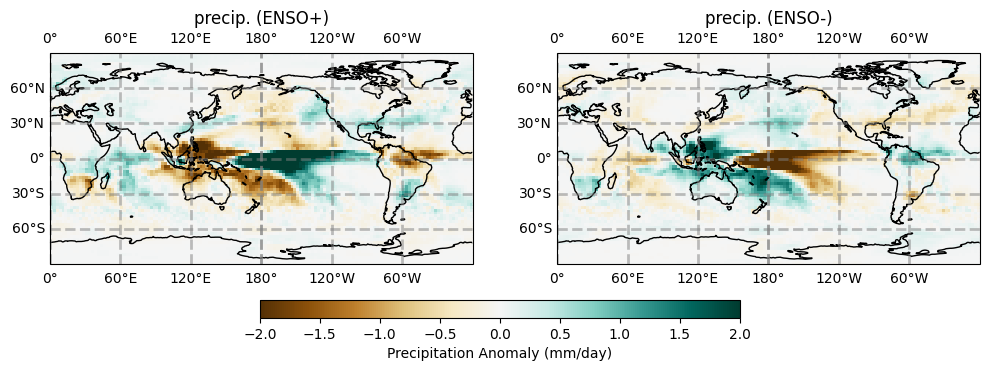

In [ ]:
# composite

# 엘니뇨/라니냐 시기를 정의에 따라 구분하여 평균을 구함
el_nino_precip = precip_anom_DJF.sel(time=nino34_DJF > 0.5).mean('time')
la_nina_precip = precip_anom_DJF.sel(time=nino34_DJF < -0.5).mean('time')

fig = plt.figure(figsize=(12, 6))

# El Niño composite
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
im1 = el_nino_precip.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='BrBG', add_colorbar=False, vmin=-2, vmax=2)
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax1.set_title('precip. (ENSO+)')

# La Niña composite
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
im2 = la_nina_precip.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='BrBG', add_colorbar=False, vmin=-2, vmax=2)
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax2.set_title('precip. (ENSO-)')

cbar_ax = fig.add_axes([0.3, 0.23, 0.4, 0.03])
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Precipitation Anomaly (mm/day)')

plt.show()

Use the bootstrapping method to test for the statistical significance at the 95% confidence level.



In [ ]:
# 엘니뇨 시기와 라니냐 시기 강수 구분
el_nino_precip = precip_anom_DJF.sel(time=nino34_DJF > 0.5)
la_nina_precip = precip_anom_DJF.sel(time=nino34_DJF < -0.5)

# 부트스트랩 횟수와 유의수준 설정
n_bootstrap = 1000
alpha = 0.05

# 유의한지 여부를 저장하는 빈 배열 생성
p_el_nino = np.empty((len(precip_anom_DJF['lat']), len(precip_anom_DJF['lon'])))
p_la_nina = np.empty((len(precip_anom_DJF['lat']), len(precip_anom_DJF['lon'])))

# 위도/경도 인덱스를 순회하며 부트스트랩 샘플링 수행
for lat_idx, lat in enumerate(precip_anom_DJF['lat']):
    for lon_idx, lon in enumerate(precip_anom_DJF['lon']):
        precip_anom = precip_anom_DJF.sel(lat=lat, lon=lon).values # 해당 위/경도에서의 시계열 데이터 수집
        el_nino_mean = el_nino_precip.sel(lat=lat, lon=lon).mean(dim='time').values # 해당 위/경도에서 엘니뇨 시기 평균 강수량 연산
        la_nina_mean = la_nina_precip.sel(lat=lat, lon=lon).mean(dim='time').values # 해당 위/경도에서 라니냐 시기 평균 강수량 연산
        # Bootstrap resampling
        bootstrap_el_nino = np.array([np.random.choice(precip_anom, size=len(el_nino_precip['time']), replace=True).mean()
                                    for _ in range(n_bootstrap)])
        # 시계열 데이터에서 엘니뇨 시기의 길이만큼 데이터를 랜덤하게 추출 후 평균 (1000회 반복, 1000개의 길이를 지닌 배열 생성)

        # 유의수준을 기반으로 기각역 설정
        lower_percentile = np.percentile(bootstrap_el_nino, 100 * (alpha / 2))
        upper_percentile = np.percentile(bootstrap_el_nino, 100 * (1 - alpha / 2))

        # 기각역 범위에 대해 검정하여 유의한 경우 True를 마킹
        if (el_nino_mean >= upper_percentile) or (el_nino_mean <= lower_percentile):
            p_el_nino[lat_idx, lon_idx] = True
        else:
            p_el_nino[lat_idx, lon_idx] = False

        # 위 과정을 라니냐에 대해 반복
        bootstrap_la_nina = np.array([np.random.choice(precip_anom, size=len(la_nina_precip['time']), replace=True).mean()
                                    for _ in range(n_bootstrap)])

        lower_percentile = np.percentile(bootstrap_la_nina, 100 * (alpha / 2))
        upper_percentile = np.percentile(bootstrap_la_nina, 100 * (1 - alpha / 2))

        if (la_nina_mean >= upper_percentile) or (la_nina_mean <= lower_percentile):
            p_la_nina[lat_idx, lon_idx] = True
        else:
            p_la_nina[lat_idx, lon_idx] = False

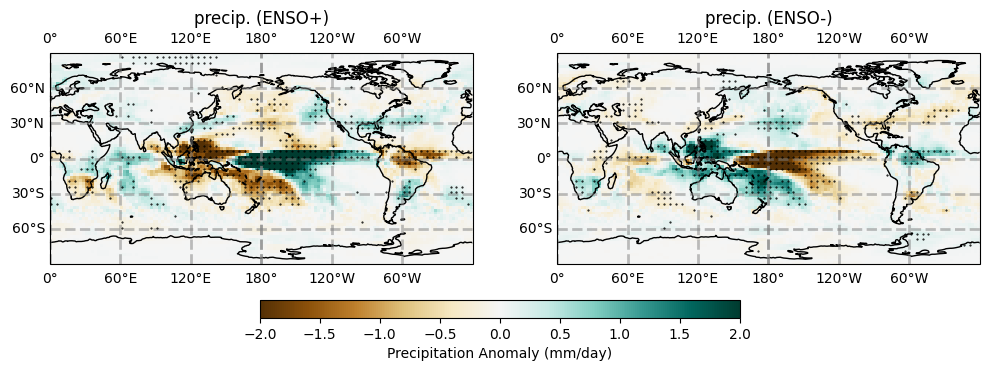

In [ ]:
el_nino_precip = precip_anom_DJF.sel(time=nino34_DJF > 0.5).mean('time')
la_nina_precip = precip_anom_DJF.sel(time=nino34_DJF < -0.5).mean('time')

fig = plt.figure(figsize=(12, 6))

# El Niño composite
ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
im1 = el_nino_precip.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='BrBG', add_colorbar=False, vmin=-2, vmax=2)
ax1.coastlines()
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.5, linestyle='--')

# 가독성을 위해 모든 점에 대해 검정하는 대신 두 칸씩 띄워서 검정 결과를 나타내기 위함
skip = 2
lon_indices = np.arange(0, len(el_nino_precip.lon), skip)
lat_indices = np.arange(0, len(el_nino_precip.lat), skip)

# lon, lat 인덱스를 순회하며 NaN이 아닌 지점에서 correlation이 95% 신뢰수준에 대해 유의한지 검정
for lon_idx in lon_indices:
        for lat_idx in lat_indices:
            lon = el_nino_precip.lon[lon_idx].values
            lat = el_nino_precip.lat[lat_idx].values
            if p_el_nino[lat_idx, lon_idx] == True: # 유의수준 설정
                ax1.plot(lon, lat, marker='o', color='k', markersize=0.5, transform=ccrs.PlateCarree())
                # 통계적으로 유의한 지점 위에 검은색 마커로 점을 기록함

gl.xlabels_top = False
gl.ylabels_right = False
ax1.set_title('precip. (ENSO+)')

# La Niña composite
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
im2 = la_nina_precip.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='BrBG', add_colorbar=False, vmin=-2, vmax=2)
ax2.coastlines()
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.5, linestyle='--')

for lon_idx in lon_indices:
        for lat_idx in lat_indices:
            lon = la_nina_precip.lon[lon_idx].values
            lat = la_nina_precip.lat[lat_idx].values
            if p_la_nina[lat_idx, lon_idx] == True: # 유의수준 설정
                ax2.plot(lon, lat, marker='o', color='k', markersize=0.5, transform=ccrs.PlateCarree())
                # 통계적으로 유의한 지점 위에 검은색 마커로 점을 기록함

gl.xlabels_top = False
gl.ylabels_right = False
ax2.set_title('precip. (ENSO-)')

cbar_ax = fig.add_axes([0.3, 0.23, 0.4, 0.03])
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Precipitation Anomaly (mm/day)')

plt.show()

Discuss whether the test results are the consistent.
If there is a region where the test results change, investigate the reason.

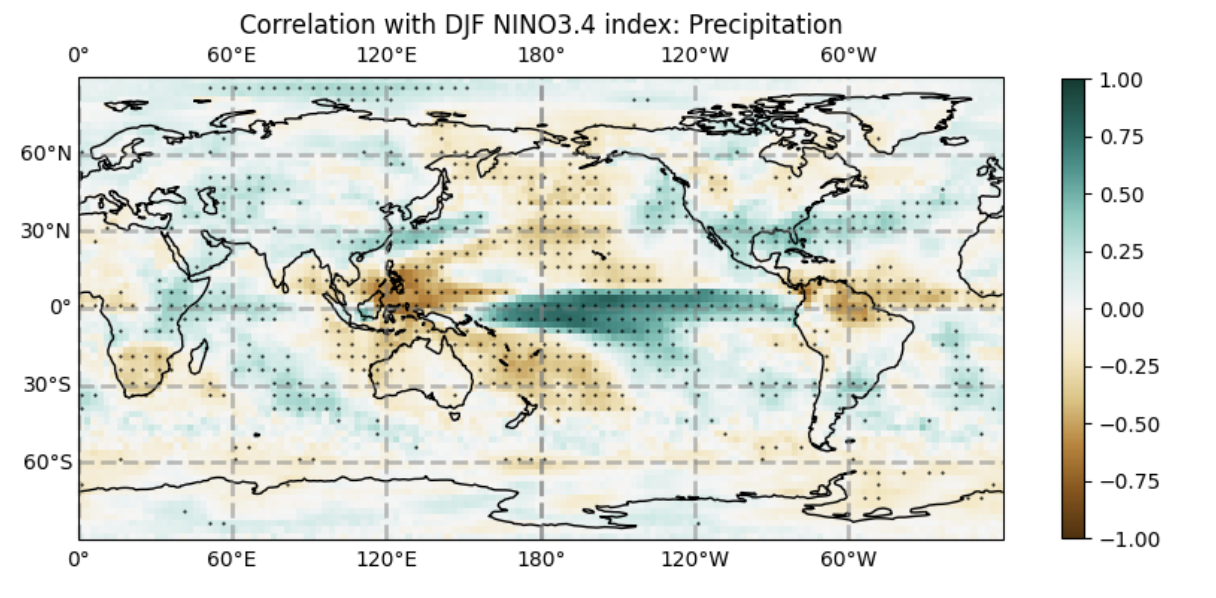

* 부트스트랩 방법을 사용한 검정 결과는 HW6의 통계적 검정 결과와 대체로 유사한 분포를 보인다.
* 분포는 유사하나 유의한 지점의 개수가 감소한 것으로 보인다. 이상치를 포함하는 기후 데이터의 특성상 정규성을 가정하는 일반적인 통계적 검정 과정에서는 이상치의 영향으로 우연한 유의성이 형성될 수 있다. 랜덤하게 샘플을 추출하는 부트스트랩 방법을 이용하면 이러한 영향이 소폭 줄어들 수 있다.
* 엘니뇨-라니냐 시기의 부트스트랩 검정 결과 사이에서는 일부 비대칭성을 보인다.